<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

You built an image classification model, evaluated it on a validation set and got a decent accuracy. Now you deploy the model for the real-world scenario. And soon, you may find that the model performs worse than expected.

This is quite common scenario (and inevitable) when we build a machine learning model because we cannot collect all the possible samples. Your model is supposed to learn the features that describe the target classes the best, but in reality, it learns the best features to classify your dataset. For example, if we have photos of *butterfly* on a flower, the model may learn flower shapes to classify *butterfly*.

<img src="./media/hard_neg_ex1.jpg" width="300"> | <img src="./media/hard_neg_ex2.jpg" width="300"> 
---|---
Did our model learn a butterfly? | or yellow flowers?

Hard negative sampling (or hard negative mining) is a useful technique to address this pitfall. It is a way to explicitly create examples for your training set from falsely classified samples. The technique is widely used when you cannot add all the negative samples since (i) training time would get too slow because of too many training samples; and (ii) many of the negative images are trivial for the model and hence the model would not learn anything. Therefore, we try to identify the images which make a difference when added to the training set.

In this notebook, we train our model on a training set as usual, test the model on un-seen negative examples and see if the model classifies them correctly. If not, we introduce those samples into the training set and re-train the model on them.

# Overview

Our goal is to train a classifier which can recognize *fridge obejcts* (`watter_bottle`, `carton`, `can`, and `milk_bottle`), similar to [01_train notebook](./01_training_introduction.ipynb). However, the input image might not even contain any of these objects in the real use-case. Therefore, we also introduce `negative` class.

<img src="./media/hard_neg.jpg" width="600"/>

The overall training process is as follows: 
* First, prepare training set <i>T</i> and negative-sample set <i>U</i>. <i>T</i> may include initial negative samples
* Next, load a pre-trained ImageNet model
* And then, mine hard negative samples by following steps as shown in the figure:
    1. Train the model on <i>T</i>
    2. Score the model on <i>U</i>
    3. Identify hard images the model mis-classified, annotate them and add to <i>T</i> so that the model can learn the patterns it confused before.
* Finally, repeat these steps until we get a good accuracy.

In [1]:
import sys

sys.path.append("../../")

import os
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from tempfile import TemporaryDirectory
from typing import Tuple
import torch
import torchvision
from torchvision import transforms
import scrapbook as sb

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.classification.data import Urls as UrlsIC
from utils_cv.detection.dataset import DetectionDataset, get_transform
from utils_cv.detection.plot import (
    display_bboxes,
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_detection_vs_ground_truth,
)
from utils_cv.detection.model import DetectionLearner, _get_det_bboxes, get_pretrained_fasterrcnn
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend('TkAgg')

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
DATA_PATH = "C:/Users/pabuehle/Desktop/ComputerVision/data/odRefrigerator"
NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)

# Number of negative samples to add for each iteration of negative mining
NEGATIVE_NUM = 10

# Using fast_inference parameters from 03_training_accuracy_vs_speed notebook.
EPOCHS = 10 #20 #10
LEARNING_RATE = 0.005
BATCH_SIZE = 2 

IM_SIZE = 600
rpn_pre_nms_top_n_train = 2000
rpn_pre_nms_top_n_test = 1000 
rpn_post_nms_top_n_train = 2000 
rpn_post_nms_top_n_test = 1000

# Temporary folder to store datasets for hard-negative mining
NEGATIVE_MINING_DATA_DIR = TemporaryDirectory().name

# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## 1. Prepare datasets

We prepare our dataset in the following way:
* The initial training set `data.train_ds` to include initially only *fridge objects* images, and after running hard-negative mining also *negative samples*<sup>+</sup>.
* Negative image set `neg_data.train_ds`.
* Validation set `data.test_ds` to have both *fridge objects* and *negative samples* from `neg_data.test_ds`. We evaluate our model on this set.

<sub>+ We added `NEGATIVE_NUM` of negative samples to our initial training set. In a real use-case, you may want to include 100 or more images of negative samples.</sub>

In [4]:
# Training and validation sets. We split positive samples into 75% training and 25% test
data = DetectionDataset(DATA_PATH, train_pct=0.75)
print(f"Positive dataset: {len(data.train_ds)} training images and {len(data.test_ds)} test images.")

# Negative set. We use most of negative set for hard-negative mining (set U) and the remaining images to test how often 
# our model incorrectly fires on these negative images.
neg_data = DetectionDataset(NEG_DATA_PATH, train_pct=0.80, batch_size=BATCH_SIZE, 
                            im_dir = "", require_annotation_files = False) 
#                            train_transforms = get_transform(train=False))
print(f"Negative dataset: {len(neg_data.train_ds)} candidates for hard negative mining and {len(neg_data.test_ds)} test images.") 

# #Add negative images to the validation set 
# neg_im_indices = neg_data.test_ds.indices
# im_paths = [neg_data.test_ds.dataset.im_paths[i] for i in neg_im_indices]
# anno_bboxes = [neg_data.test_ds.dataset.anno_bboxes[i] for i in neg_im_indices]
# data.add_images(im_paths, anno_bboxes, target = "test")
# print(f"Positive dataset with negatives: {len(data.train_ds)} training images and {len(data.test_ds)} test images")

Positive dataset: 23 training images and 7 test images.
Negative dataset: 52 candidates for hard negative mining and 12 test images.


In [5]:
# # Add random NEGATIVE_NUM negatives to the training data
# neg_im_indices = np.random.randint(len(neg_data.train_ds.dataset.im_paths)-1, size=NEGATIVE_NUM)
# im_paths = [neg_data.train_ds.dataset.im_paths[i] for i in neg_im_indices]
# anno_bboxes = [neg_data.train_ds.dataset.anno_bboxes[i] for i in neg_im_indices]
# data.add_images(im_paths, anno_bboxes, target = "train")

## 2. Prepare a model

We use *fast inference* setup we demonstrated from [02_training_accuracy_vs_speed notebook](./02_training_accuracy_vs_speed.ipynb). The model is Resnet18 and pre-trained on [ImageNet](http://www.image-net.org/). Regarding the details about training concept, please see [01_training notebook](./01_training_introduction.ipynb).

In [6]:
model = get_pretrained_fasterrcnn(
    num_classes=len(data.labels) + 1, min_size=IM_SIZE, max_size=IM_SIZE
)
detector = DetectionLearner(data, model=model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [7]:
# We record the validdation accuracy and how many objects were found in the negative test set for later analysis
valid_accs = []
nr_neg_detections = []

## 3. Train the model on *T*

<a id='train'></a>

From this section to the end, we do training and negative mining. As described in the Overview section, You may need to do repeat the negative mining steps several times to achieve good results.

In [45]:
detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30)

Epoch: [0]  [ 0/12]  eta: 0:00:06  lr: 0.000459  loss: 0.0456 (0.0456)  loss_classifier: 0.0251 (0.0251)  loss_box_reg: 0.0107 (0.0107)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 0.5468  data: 0.4375  max mem: 1652
Epoch: [0]  [11/12]  eta: 0:00:00  lr: 0.005000  loss: 0.0514 (0.0594)  loss_classifier: 0.0186 (0.0205)  loss_box_reg: 0.0098 (0.0093)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0098 (0.0271)  time: 0.4550  data: 0.3435  max mem: 1652
Epoch: [0] Total time: 0:00:05 (0.4550 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0469 (0.0469)  evaluator_time: 0.0000 (0.0000)  time: 0.1719  data: 0.1250  max mem: 1652
Test:  [3/4]  eta: 0:00:00  model_time: 0.0469 (0.0430)  evaluator_time: 0.0000 (0.0000)  time: 0.1607  data: 0.1138  max mem: 1652
Test: Total time: 0:00:00 (0.1607 s / it)
Averaged stats: model_time: 0.0469 (0.0430)  evaluator_time: 0.0000 (0.0000)
Accumulating evaluation results...
DONE (

Epoch: [4]  [ 0/12]  eta: 0:00:06  lr: 0.005000  loss: 0.0603 (0.0603)  loss_classifier: 0.0281 (0.0281)  loss_box_reg: 0.0148 (0.0148)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 0.5501  data: 0.4251  max mem: 1652
Epoch: [4]  [11/12]  eta: 0:00:00  lr: 0.005000  loss: 0.0649 (0.0881)  loss_classifier: 0.0194 (0.0223)  loss_box_reg: 0.0148 (0.0140)  loss_objectness: 0.0013 (0.0034)  loss_rpn_box_reg: 0.0189 (0.0484)  time: 0.4683  data: 0.3533  max mem: 1652
Epoch: [4] Total time: 0:00:05 (0.4683 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0312 (0.0312)  evaluator_time: 0.0156 (0.0156)  time: 0.1719  data: 0.1094  max mem: 1652
Test:  [3/4]  eta: 0:00:00  model_time: 0.0312 (0.0391)  evaluator_time: 0.0000 (0.0039)  time: 0.1523  data: 0.1055  max mem: 1652
Test: Total time: 0:00:00 (0.1523 s / it)
Averaged stats: model_time: 0.0312 (0.0391)  evaluator_time: 0.0000 (0.0039)
Accumulating evaluation results...
DONE (

Epoch: [8]  [ 0/12]  eta: 0:00:06  lr: 0.000500  loss: 0.0668 (0.0668)  loss_classifier: 0.0094 (0.0094)  loss_box_reg: 0.0035 (0.0035)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0520 (0.0520)  time: 0.5156  data: 0.3906  max mem: 1652
Epoch: [8]  [11/12]  eta: 0:00:00  lr: 0.000500  loss: 0.0506 (0.0521)  loss_classifier: 0.0168 (0.0191)  loss_box_reg: 0.0074 (0.0076)  loss_objectness: 0.0008 (0.0017)  loss_rpn_box_reg: 0.0118 (0.0237)  time: 0.4851  data: 0.3730  max mem: 1652
Epoch: [8] Total time: 0:00:05 (0.4864 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0469 (0.0469)  evaluator_time: 0.0000 (0.0000)  time: 0.1562  data: 0.1094  max mem: 1652
Test:  [3/4]  eta: 0:00:00  model_time: 0.0469 (0.0430)  evaluator_time: 0.0000 (0.0000)  time: 0.1487  data: 0.1057  max mem: 1652
Test: Total time: 0:00:00 (0.1526 s / it)
Averaged stats: model_time: 0.0469 (0.0430)  evaluator_time: 0.0000 (0.0000)
Accumulating evaluation results...
DONE (

The following cell shows confusion matrix for the validation set. If you are repeating the negative mining steps, you will see all the confusion matrices from the repetitions.

In [46]:
# Get accuracy on test set at IOU=0.5:0.95
acc = float(detector.ap[-1])
valid_accs.append(acc)

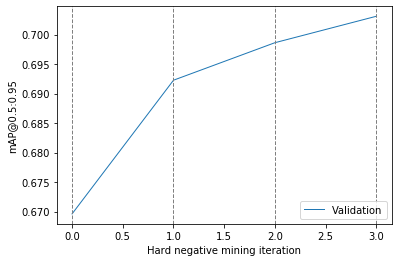

In [47]:
# Plot validation accuracy versus number of hard-negative mining iterations
from utils_cv.common.plot import line_graph
line_graph(
    values=(valid_accs), #, valid_acc),
    labels=("Validation"), #, "Valid"),
    x_guides=range(len(valid_accs)), #[i*EPOCHS for i in range(1, len(valid_accs)//EPOCHS + 1)],
    x_name="Hard negative mining iteration",
    y_name="mAP@0.5:0.95",
)

**If the model performs well enough, we can stop the training / negative sampling here.**

If not, let's do hard negative sampling.

## 4. Score the model on *U* 

Run inference on all candidate images for hard negative mining. The images with worst accuracy will later be added to the training set.

In [48]:
detections = detector.predict_dl(neg_data.train_dl, threshold=0)
detections[0]

{'idx': 19,
 'det_bboxes': [{Bbox object: [left=115, top=271, right=283, bottom=397] | <squash> | label:8 | path:C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjectsNegative\IMG_1818.jpg} | score: 0.8109332323074341,
  {Bbox object: [left=112, top=270, right=283, bottom=396] | <orange> | label:6 | path:C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjectsNegative\IMG_1818.jpg} | score: 0.10550682246685028,
  {Bbox object: [left=284, top=196, right=361, bottom=290] | <squash> | label:8 | path:C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjectsNegative\IMG_1818.jpg} | score: 0.08042100816965103,
  {Bbox object: [left=345, top=178, right=432, bottom=322] | <squash> | label:8 | path:C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjectsNegative\IMG_1818.jpg} | score: 0.07457024604082108]}

Count how many objects were detected in the negative test set. This number typically goes down dramatically after a few hard negative sampling iterations, and is an indicator how much the model over-fires on unseen images.

In [49]:
test_detections = detector.predict_dl(neg_data.test_dl, threshold=0)
bbox_scores = [bbox.score for det in test_detections for bbox in det['det_bboxes']]
nr_neg_detections.append(len(bbox_scores))

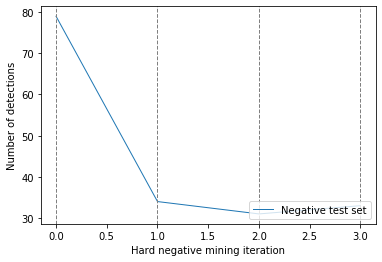

In [50]:
# Plot number of detections in negative test set versus number of hard-negative mining iterations
from utils_cv.common.plot import line_graph
line_graph(
    values=(nr_neg_detections), 
    labels=("Negative test set"),
    x_guides=range(len(nr_neg_detections)), 
    x_name="Hard negative mining iteration",
    y_name="Number of detections",
)

## 5. Hard negative mining

In [51]:
# For each image, get maximum score over all detected bounding boxes in the image
max_scores = []
for idx, detection in enumerate(detections):
    if len(detection['det_bboxes']) > 0:
        max_score = max([d.score for d in detection['det_bboxes']])
    else:
        max_score = float('-inf')
    max_scores.append(max_score)

In [52]:
# Get the n images with highest maximum score 
hard_im_ids = np.argsort(max_scores)[::-1]
hard_im_ids = hard_im_ids[:NEGATIVE_NUM]
hard_im_scores =[max_scores[i] for i in hard_im_ids]
print(f"Identified {len(hard_im_scores)} hard negative images with detected objects in range {min(hard_im_scores)} to {max(hard_im_scores):4.2f}")

Identified 10 hard negative images with detected objects in range 0.912063479423523 to 0.99


In [53]:
#im_paths = [neg_data.train_ds.dataset.im_paths[detections[i]['idx']] for i in hard_im_ids]
#gt_bboxes = [neg_data.train_ds.dataset.anno_bboxes[detections[i]['idx']] for i in hard_im_ids]
#det_bboxes = [detections[i]['det_bboxes'] for i in hard_im_ids]

# Plot a single image
#plot_grid(plot_detection_vs_ground_truth, zip(im_paths, gt_bboxes, det_bboxes), rows=2, cols=3)

## 6. Add hard negative samples to the training set *T*

We add the hard negative samples into the training set.

In [54]:
dataset_ids = [detections[i]['idx'] for i in hard_im_ids]
im_paths = [neg_data.train_ds.dataset.im_paths[i] for i in dataset_ids]
gt_bboxes = [neg_data.train_ds.dataset.anno_bboxes[i] for i in dataset_ids]

data.add_images(im_paths, gt_bboxes, target = "train")
print(f"Completed {len(valid_accs)} hard negative iterations.")
print(f"Positive dataset with negatives: {len(data.train_ds)} training images and {len(data.test_ds)} test images")

# Preserve some of the notebook outputs
sb.glue("valid_accs", valid_accs)
sb.glue("hard_im_ids", list(hard_im_ids))

Completed 4 hard negative iterations.
Positive dataset with negatives: 23 training images and 7 test images


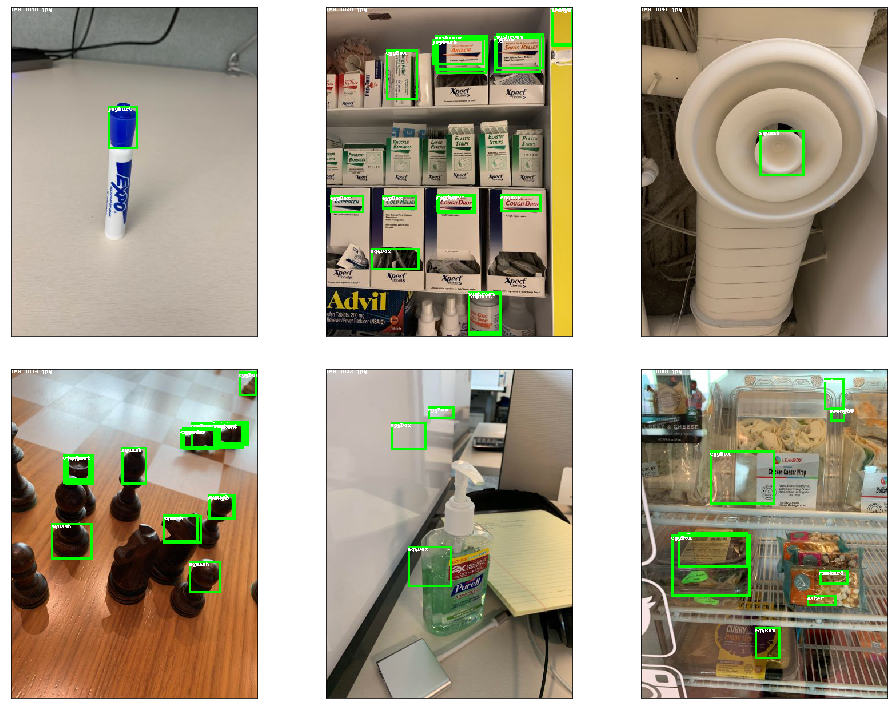

In [55]:
# Plot some of the images which were added to the training set.
det_bboxes = [detections[i]['det_bboxes'] for i in hard_im_ids]
plot_grid(plot_detection_vs_ground_truth, zip(im_paths, gt_bboxes, det_bboxes), rows=2, cols=3)

## Repeat

Now, **repeat** all steps starting from "[3. Train the model on T](#train)" to re-training the model and add more hard negative images to the training set. Stop once the accuracy `valid_accs` stops improving and if the number of (mis)detections in the negative test set `nr_neg_detections` stops decreasing. 